<a href="https://colab.research.google.com/github/KiltCross/Character-generator/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 

print(tf.version)

#!pip install --upgrade tensorflow

from tensorflow.keras import layers

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
import IPython.display as display

import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import imageio

import math 

from IPython import display

import matplotlib.image as mpimg

In [4]:
!pip install -q pyyaml h5py

This allow to this notebook to access the drive files

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


This load the saved model

In [ ]:
generator = tf.keras.models.load_model("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/generator.h5")
discriminator = tf.keras.models.load_model("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/discriminator.h5")

Setting the metadata

In [18]:
def metadata(desire_data, desire_data_of_desire_data=False):
  switcher = {
      'image_shape': [128,64,4], #shape of the images
      'mini_batch_size': 244, #size of the mini batches what the images are diveded
      'batch_size': 24*2, #total of mini batches. (24 for recolor and 2 for swamp)
      'pre_train_discriminator_epoch': 1, #epochs of the discriminador pre-training
      'pre_train_generator_epoch': 50, #epochs of the generador pre-training
      'train_epoch': 1, #epochs of the meain training
      'pre_train_batch_size':  1, #quantity of mini batches used to do the pre training (pre main training) training
      'train_batch_size': 1, #quantity of mini batches used to do the training
      'test_batch_size': 1, #quantity of mini batches used to do the testing
      'seed_lenght': 128 #it is the lenght of the seed what the generator uses to generate the images
  }
  return switcher.get(desire_data)[desire_data_of_desire_data] if desire_data_of_desire_data else switcher.get(desire_data)

In [7]:
def image_resize(img, new_size=[128,64]):
  new_size[0] , new_size[1] = new_size[1], new_size[0]
  img = Image.fromarray((img*255).astype(np.uint8),"RGBA")
  img = img.resize(new_size)
  img = np.array(img)/255
  return img

Setting the function what import the databases

In [8]:
#the ds is divided on groups of 244 images, and the batch size is in units of this groups

def DS(desired_ds='train', batch_size=int(2*24), train_batch_size = (5), test_batch_size = (1), pre_train_batch_size = (1), mini_batch_size=(244), image_shape=[128,64,4]):

  train_batch_size = int(train_batch_size * mini_batch_size)
  test_batch_size = int(test_batch_size * mini_batch_size)
  pre_train_batch_size = int(pre_train_batch_size * mini_batch_size)

  last_timing = time.time()
  time_elapsed = 0
  count = 0

  if (desired_ds == 'train'):
    print("Importing main training database")
    ds = np.zeros([train_batch_size,image_shape[0],image_shape[1],image_shape[2]], dtype='float32')
    for train_image in range(train_batch_size):

      start = time.time()
      count += 1
      time_left = (time_elapsed/count)*(train_batch_size-count)

      ds[train_image] =  image_resize(mpimg.imread("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/Data_set/0"+str(train_image+1)+".png"),image_shape[:2])
      time_elapsed += (start - last_timing)
      print("Image number: "+str(train_image+1)+"/"+str(train_batch_size)+"  |  Time left: "+str(int(time_left/3512))+" hours - "+str(int((time_left%3512)/60))+" minutes - "+str(int(time_left%60))+" seconds  |  Time elapsed: "+str(int(time_elapsed/(60*60)))+" hours - "+str(int(time_elapsed%(60*60)/60))+" minutes - "+str(int(time_elapsed%60))+" seconds")
      
      last_timing = start

    ds = tf.reshape(ds, [train_batch_size,image_shape[0],image_shape[1],image_shape[2],1])
    ds = tf.random.shuffle(ds)

  if (desired_ds == 'test'):
    print("Importing test database")
    ds = np.zeros([test_batch_size,image_shape[0],image_shape[1],image_shape[2]], dtype='float32')
    for test_image in range(test_batch_size):

      start = time.time()
      count += 1
      time_left = (time_elapsed/count)*(test_batch_size-count)

      ds[test_image] = image_resize(mpimg.imread("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/Data_set/0"+str(train_batch_size + test_image+1)+".png"),image_shape[:2])
      time_elapsed += (start - last_timing)
      print("Image number: "+str(test_image+1)+"/"+str(test_batch_size)+"  |  Time left: "+str(int(time_left/3512))+" hours - "+str(int((time_left%3512)/60))+" minutes - "+str(int(time_left%60))+" seconds  |  Time elapsed: "+str(int(time_elapsed/(60*60)))+" hours - "+str(int(time_elapsed%(60*60)/60))+" minutes - "+str(int(time_elapsed%60))+" seconds")

      last_timing = start      

    ds = tf.reshape(ds, [test_batch_size,image_shape[0],image_shape[1],image_shape[2],1])
    ds = tf.random.shuffle(ds)


  if (desired_ds == 'pre_train'):
    print("Importing training pre main training database")
    ds = np.zeros([pre_train_batch_size,image_shape[0],image_shape[1],image_shape[2]], dtype='float32')
    for pre_train_image in range(pre_train_batch_size):

      start = time.time()
      count += 1
      time_left = (time_elapsed/count)*(pre_train_batch_size-count)      

      image_num = (train_batch_size + test_batch_size) + pre_train_image+1
      ds[pre_train_image] = image_resize(mpimg.imread("gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/Data_set/0"+str(image_num)+".png"),image_shape[:2])
      time_elapsed += (start - last_timing)
      print("Image number: "+str(pre_train_image+1)+"/"+str(pre_train_batch_size)+"  |  Time left: "+str(int(time_left/3512))+" hours - "+str(int((time_left%3512)/60))+" minutes - "+str(int(time_left%60))+" seconds  |  Time elapsed: "+str(int(time_elapsed/(60*60)))+" hours - "+str(int(time_elapsed%(60*60)/60))+" minutes - "+str(int(time_elapsed%60))+" seconds")

      last_timing = start  

    ds = tf.reshape(ds, [pre_train_batch_size,image_shape[0],image_shape[1],image_shape[2],1])
    ds = tf.random.shuffle(ds)
  return ds


Model builder

In [9]:
def generator_model(primary_activation_function=None, semi_final_activation_function='tanh',  final_activation_function='sigmoid', seed_lenght=128, alpha = 0.2, momentum = 0.8, kernel = (4, 4, 4)):

  model = tf.keras.Sequential()
  model.add(layers.Dense(1*1*1*128, input_shape=(seed_lenght,), use_bias=False, name='Dense_G_1'))
  model.add(layers.BatchNormalization(momentum=momentum))
  model.add(layers.LeakyReLU(alpha))

  model.add(layers.Reshape((1,1,1,128)))

  model.add(layers.Conv3DTranspose(128, kernel_size=kernel, strides=(2, 2, 1), padding='same', use_bias=False, activation=primary_activation_function, name='Conv3DTranspose_G_1'))
  model.add(layers.BatchNormalization(momentum=momentum))
  model.add(layers.LeakyReLU(alpha))

  model.add(layers.Conv3DTranspose(256, kernel_size=kernel, strides=(4, 2, 2), padding='same', use_bias=False, activation=primary_activation_function, name='Conv3DTranspose_G_2'))
  model.add(layers.BatchNormalization(momentum=momentum))
  model.add(layers.LeakyReLU(alpha))

  model.add(layers.Conv3DTranspose(512, kernel_size=kernel, strides=(4, 4, 1), padding='same', use_bias=False, activation=semi_final_activation_function, name='Conv3DTranspose_G_3'))
  model.add(layers.BatchNormalization(momentum=momentum))
  model.add(layers.LeakyReLU(alpha))


  model.add(layers.Conv3DTranspose(1, kernel_size=kernel, strides=(4, 4, 2), padding='same', use_bias=False, activation=final_activation_function, name='Conv3DTranspose_G_Final'))


  return model

In [10]:
def discriminator_model(primary_activation_function=None, semi_final_activation_function=None, final_activation_function='sigmoid', input_shape=[128,64,4], alpha = 0.2, dropout = 0.3, kernel = (4, 4, 4)):

  model = tf.keras.Sequential()

  model.add(layers.Conv3D(64, kernel_size=kernel, strides=(2, 2, 1), padding='same', activation=primary_activation_function, name='Dense_D_1', input_shape=[input_shape[0], input_shape[1], input_shape[2], 1]))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.Dropout(dropout))


  model.add(layers.Conv3D(128, kernel_size=kernel, strides=(4, 2, 2), padding='same', activation=primary_activation_function, name='Dense_D_2'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.Dropout(dropout))

  model.add(layers.Conv3D(256, kernel_size=kernel, strides=(4, 4, 1), padding='same', activation=primary_activation_function, name='Dense_D_3'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.Dropout(dropout))

  model.add(layers.Conv3D(512, kernel_size=kernel, strides=(4, 4, 2), padding='same', activation=semi_final_activation_function, name='Dense_D_4'))
  model.add(layers.LeakyReLU(alpha))
  model.add(layers.Dropout(dropout))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation=final_activation_function, name='Dense_D_Final'))


  return model

Model functionality test:

tf.Tensor([[0.501294]], shape=(1, 1), dtype=float32)


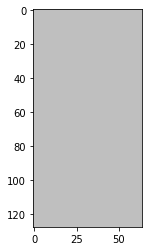

In [11]:
generator = generator_model(seed_lenght=metadata("seed_lenght"))

discriminator = discriminator_model(input_shape=metadata("image_shape"), final_activation_function='sigmoid')

#generator.summary()

#discriminator.summary()

with tf.device('/CPU:0'):

  seed = tf.random.normal([1,metadata("seed_lenght")])

  generated_image = generator(seed, training=False)

  generated_image.shape

  result = discriminator(generated_image, training=False) 
  
  plt.imshow(generated_image[0,:,:,:,0])  

  print(result)


Setting some useful varibles

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(0.002, beta_1=0.5)

discriminator_optimizer = tf.keras.optimizers.Adam(0.002, beta_1=0.5)

mean_squared = tf.keras.losses.mean_squared_error

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


Setting the generator loss

In [13]:
def generator_loss_function(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Setting the discriminator loss

In [14]:
def discriminator_loss_function(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Train function part 1 of 2:

In [15]:
def train_step(image, image_shape=[128,64,4], seed_lenght=128):

    seed = tf.random.normal([1,seed_lenght])

    image = tf.reshape(image, [1,image_shape[0],image_shape[1],image_shape[2],1])

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:

      generated_image = generator(seed, training=True)

      #This is for evoid an inexplicable shape error
      generated_image.shape

      real_output = discriminator(image, training=True)
      fake_output = discriminator(generated_image, training=True)

      generator_loss = generator_loss_function(fake_output)
      discriminator_loss = discriminator_loss_function(real_output, fake_output)

      gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)
      gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)

      
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    
 


Train function part 2 of 2:

In [16]:
def train(images, epochs, image_shape=[128,64,4], seed_lenght=128):

  last_timing = time.time()
  time_elapsed = 0
  count = 0

  for epoch in range(epochs):

      for batch_num in range(images.shape[0]):
        start = time.time()
        count += 1
        train_step(images[batch_num], image_shape, seed_lenght)
        time_elapsed += (start - last_timing)
        time_left = (time_elapsed/count)*((images.shape[0]*epochs)-count)
        print("Image number: "+str(batch_num+1)+"/"+str(images.shape[0])+"  |  Epoch: "+str(epoch+1)+"/"+str(epochs)+"  |  Iteration: "+str(count)+"/"+str(images.shape[0]*epochs)+"  |  Iteration duration: "+str(start - last_timing)+" seconds  |  Time left: "+str(int(time_left/3512))+" hours - "+str(int((time_left%3512)/60))+" minutes - "+str(int(time_left%60))+" seconds  |  Time elapsed: "+str(int(time_elapsed/(60*60)))+" hours - "+str(int(time_elapsed%(60*60)/60))+" minutes - "+str(int(time_elapsed%60))+" seconds")
        last_timing = start

  print("Finish!, take: "+str(int(time_elapsed/(60*60)))+":"+str(int(time_elapsed%(60*60)/60))+":"+str(int(time_elapsed%60)))


Importing the databases

In [ ]:
pre_train_ds=DS('pre_train',pre_train_batch_size=metadata("pre_train_batch_size"), mini_batch_size=metadata("mini_batch_size"), image_shape=metadata("image_shape"))

In [ ]:
train_ds=DS('train', train_batch_size=(metadata("train_batch_size")), mini_batch_size=metadata("mini_batch_size"), image_shape=metadata("image_shape"))

In [ ]:
test_ds=DS('test', test_batch_size=metadata("test_batch_size"), mini_batch_size=metadata("mini_batch_size"), image_shape=metadata("image_shape"))

Train test part:

In [ ]:
answer = np.ones([metadata("pre_train_batch_size")*metadata("mini_batch_size"), 1], dtype='float32')
#Pre-trainig the discriminator
with tf.device('/GPU:0'), tf.device('/CPU:0'):

  discriminator.compile(optimizer=discriminator_optimizer, loss=cross_entropy, metrics=['accuracy'])
  discriminator.fit(x=pre_train_ds, y=answer, batch_size=metadata("pre_train_batch_size")*metadata("mini_batch_size"), use_multiprocessing=True, epochs=metadata("pre_train_discriminator_epoch"))

1/1 [==============================] - 0s 1ms/step - loss: 0.3133 - accuracy: 1.0000


In [ ]:
seed = tf.random.normal([metadata("pre_train_batch_size")*metadata("mini_batch_size"),metadata("seed_lenght")])
#Pre-trainig the generator
with tf.device('/GPU:0'), tf.device('/CPU:0'):

  generator.compile(optimizer=generator_optimizer, loss=cross_entropy, metrics=['accuracy'])
  generator.fit(x=seed, y=pre_train_ds, batch_size=(metadata("pre_train_batch_size")*metadata("mini_batch_size")), use_multiprocessing=True, epochs=metadata("pre_train_generator_epoch"))

In [ ]:

#fitting the model

with tf.device('/GPU:0'):

  train(train_ds, metadata("train_epoch"), metadata("image_shape"), metadata("seed_lenght"))


Testing the training

In [ ]:
  discriminator.compile(optimizer=discriminator_optimizer, loss=cross_entropy, metrics=['accuracy'])

  test_ds = test_ds

  seed = tf.random.normal([1,metadata("seed_lenght")])

  anwser = np.ones([metadata("test_batch_size")*metadata("mini_batch_size"), 1])

  discriminator_test = train_ds[0]
  discriminator_test = tf.reshape(discriminator_test, [1,metadata("image_shape",0),metadata("image_shape",1),metadata("image_shape",2),1])

  generated_image = generator(seed, training=False)

  plt.imshow(generated_image[0,:,:,:,0]) #print a image generated by the generator

  perspective = discriminator(discriminator_test, training=False)
  test_of_training = discriminator.evaluate(test_ds, anwser)
  criterio = discriminator(generated_image, training=False)

  print(perspective) #how the discriminator classifies a image used to train it
  print(test_of_training) #a evaluation of the discriminator with a test database
  print(criterio) #how the dicriminator classifies a image generated by the generator



Saving the trained model

In [ ]:
discriminator.save('gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/discriminator.h5')
generator.save('gdrive/My Drive/Colab Notebooks/Equestria_girls_character_generator/generator.h5')

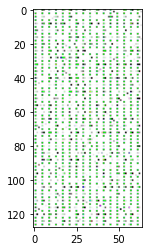

In [26]:
#ones=tf.ones([1,metadata("seed_lenght")])
seed = tf.random.normal([1,metadata("seed_lenght")])
plt.imshow(generator(seed, training=False)[0,:,:,:,0])